## Individual Proposal

#### Broad Question
Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

#### Specific Question
Does the background of a player (Age, Experience) predictd how long they are on the server? 

This question addresses the overall question as if people play for longer, they will contribute more data for the experiment. Thus, if we can see and predict what groups of players (based on age and experience) will contribute the most data, we can then identify the groups that we should target in recruiting.

### Data <br />

The data consists of 2 datasets, for a total of 9 variables (excluding id's such as name and hashed emails) which are: <br />

Dataset: sessions.csv <br />
- `start_time`: Start time and date formatted as `DD/MM/YYYY hh:mm`<br />
- `end_time`: End time and date formatted as `DD/MM/YYYY hh:mm`<br />
- `original_start_time`: Start time and date formatted in `UNIX (ms)`<br />
- `original_end_time`: End time and date formatted in `UNIX (ms)`<br />

Dataset: players.csv <br />
- `experience`: Experience level of player as a string that can be a value of :`Pro`, `Veteran`, `Regular`, `Amateur`, `Beginner`.<br />
- `subscribe`: Is the person subscribed to the newsletter? Formatted as `Boolean (lgl)`<br />
- `played_hours`: How many hours the person has played, formatted as `double (dbl)`.<br />
- `gender`: Gender of respondent, `String value`. <br />
- `Age`: Age of respondent, `double (dbl)` <br />

The summary of this data is found below under "Summarizing Data"

### Plan

We will use the players dataset to see if the background of the player can be used to predict how long they would play. This is useful as if more people play for longer, than more licenses will be needed. In order to achieve this, we will predict using 
k nearest neighbours regression. This is a suitable method as we are predicting a contious variable rather than a discrete one, so we cannot use classificaiton methods. Since we don't know the relationship, and we are also using experience in a numeric form, we don't know if the resulting relationship will be linear. Thus, a knn regression will probably yield more accurate results. A key limitation of this is that we will need to factor in discrete data (experience, gender) into this calculation, although there are ways to format it to make it viable. 

We will create a model by using age, experience (converted to numeric) as our independent variables, and the playtime as our dependent variable. We will then use k nearest neighbour regression to create a model to predict playtime of new players. We will split the data into a training and a testing dataset, so that we can validate our model after we create it. This split will likely be a 60/30 split. For non numeric data, we will convert each unique data value into a number. For experience, we will have beginner as 0.2, and move up in experience until we get pro as 1. This allows us to avoid normalization for this variable. We will have to normalize age to a value between 0 and 1. 

### Initial Data Wrangling and Summary Statistics


#### Libraries and Config:

In [25]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


### Loading and Cleaning Data

In [15]:
raw_data <- read_csv("data/players.csv")
cleaned_data <- raw_data |>
    na.omit() |>
    mutate(age = Age) |>
    select(-Age, -hashedEmail, -name) 
cleaned_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,age
<chr>,<lgl>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Male,22
Amateur,FALSE,0.0,Prefer not to say,57
Amateur,FALSE,2.3,Male,17


### Summarizing Data

In [27]:
summarized_numeric_data <- cleaned_data |>
    summarise(
        mean(played_hours),
        mean(age)
)
summarized_numeric_data

mean(played_hours),mean(age)
<dbl>,<dbl>
5.904639,21.13918


### Table of Summarized Data:
||Play Time (Hours)|Age (Years)
|---|---|---|
||5.90|21.14|


### Visualizing Data

#### Played hours versus age:

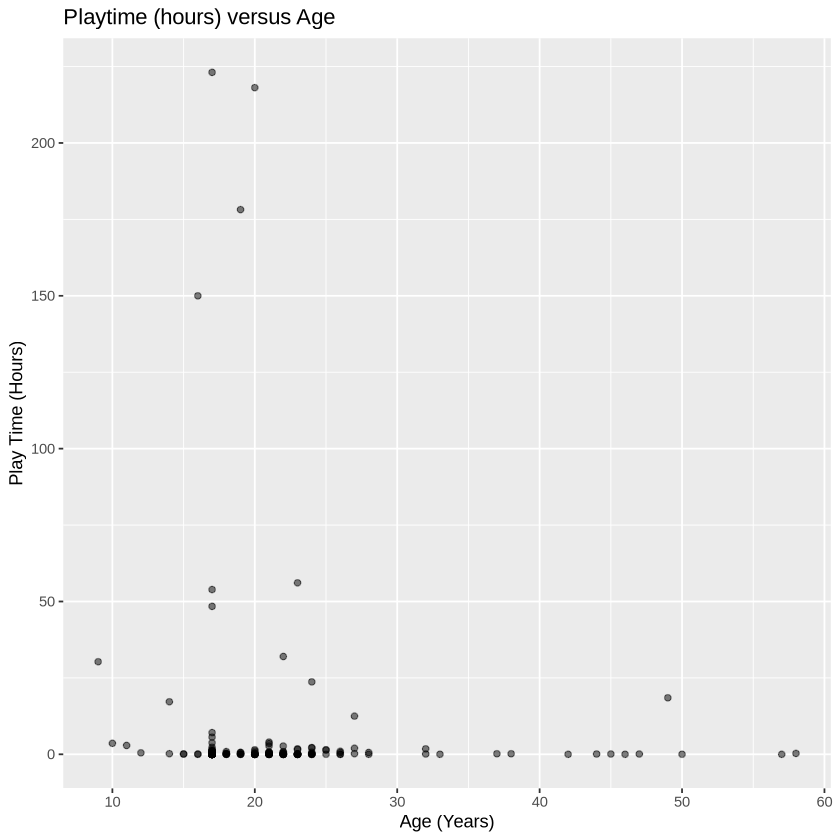

In [43]:
play_hours_v_age <- cleaned_data |>
    ggplot(aes(x = age, y = played_hours)) +
        geom_point(alpha = 0.5) + 
        labs(title = "Playtime (hours) versus Age", x = "Age (Years)", y = "Play Time (Hours)")
play_hours_v_age 

From this data, we can see that it is mostly clustered near 0 hours. In order to be able to see the majority of the data points, we will filter out any values above 10, and regraph to see the cluster: 

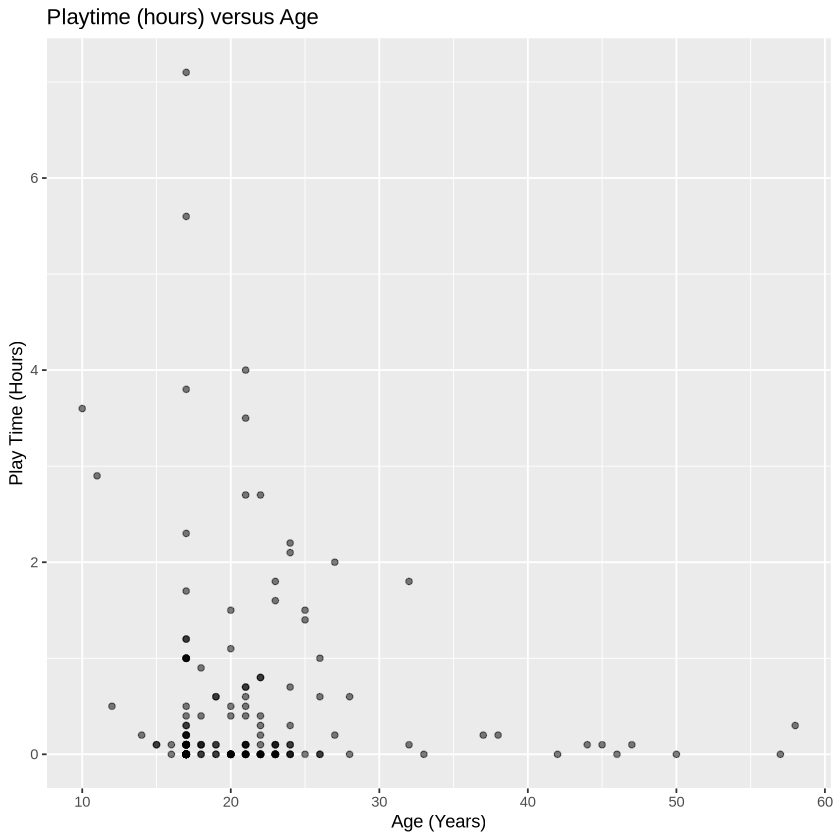

In [42]:
play_hours_v_age_zoomed <- cleaned_data |>
    filter(played_hours < 10) |>
        ggplot(aes(x = age, y = played_hours)) +
            geom_point(alpha = 0.5) + 
            labs(title = "Playtime (hours) versus Age", x = "Age (Years)", y = "Play Time (Hours)")
play_hours_v_age_zoomed

Fascinatingly, we see the same general shape and distribution as when we looked at the full dataset, with what appears to be a skewed bell curve with a center at around 18. We also see a clear relationship between play time and age, which is part of what we will be predicting under our proposed model. This also validates our decision to use knn regression over linear regression, as our data is clearly non linear, with a positive relationship up until around 18 years old, then a negative relationship after that.

#### Next we will add the experience into our visualization:

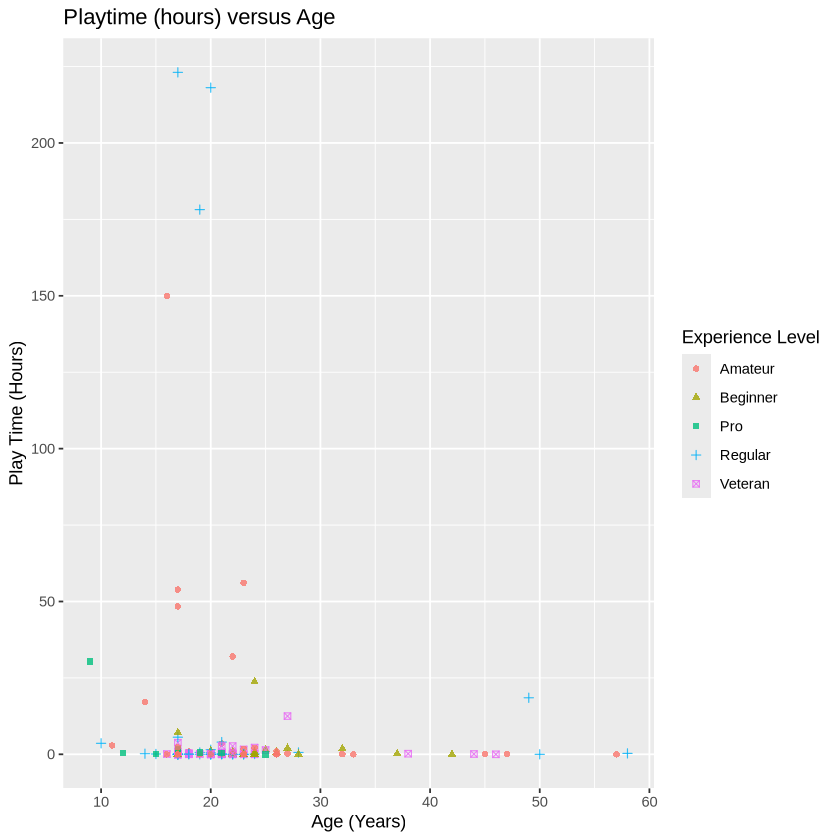

In [41]:
play_hours_v_age_experience <- cleaned_data |>
    ggplot(aes(x = age, y = played_hours)) +
            geom_point(alpha = 0.8, aes(colour = experience, shape = experience)) + 
            labs(title = "Playtime (hours) versus Age", x = "Age (Years)", y = "Play Time (Hours)", colour = "Experience Level", shape ="Experience Level")
play_hours_v_age_experience

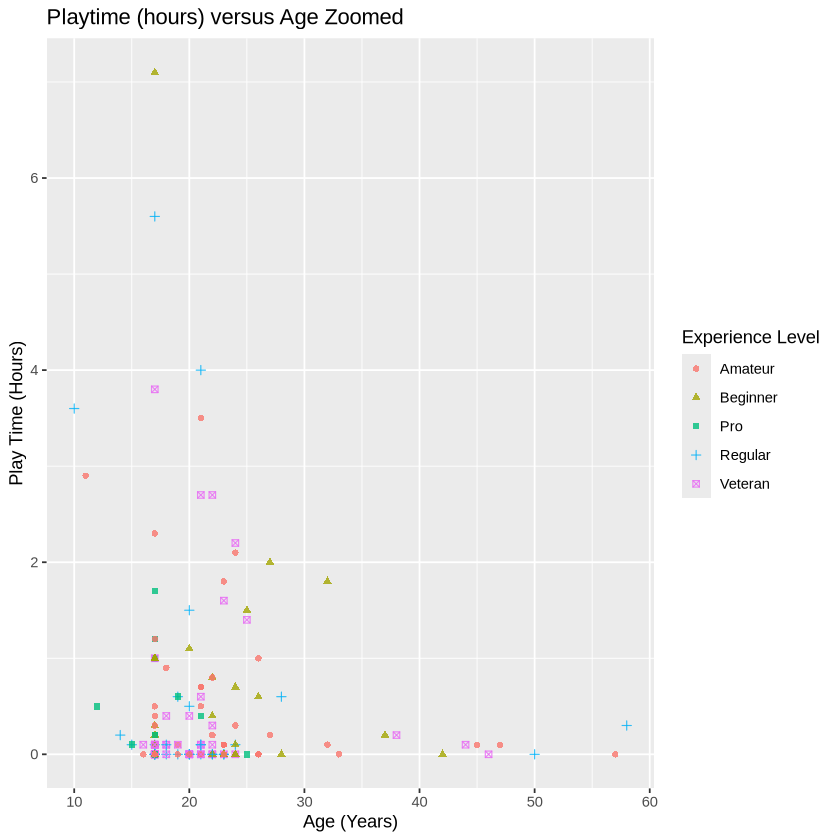

In [44]:
play_hours_v_age_experience_zoomed <- cleaned_data |>
    filter(played_hours < 10) |>
    ggplot(aes(x = age, y = played_hours)) +
            geom_point(alpha = 0.8, aes(colour = experience, shape = experience)) + 
            labs(title = "Playtime (hours) versus Age Zoomed", x = "Age (Years)", y = "Play Time (Hours)", colour = "Experience Level", shape ="Experience Level")
play_hours_v_age_experience_zoomed

From these two graphs, we see that there is no apparent relationship between experience level and our other two variables. This does not mean one doesnt exist, but it does show that it will be much messier or complex of a relationship compared to age, and we will probably encounter a lot more trouble in our predictions using experience as a predictor.

#### Next we will visualize experience versus playtime:

In [47]:
#removing Age:
data_qualitative <- cleaned_data |>
    select(-age)
data_qualitative

experience,subscribe,played_hours,gender
<chr>,<lgl>,<dbl>,<chr>
Pro,TRUE,30.3,Male
Veteran,TRUE,3.8,Male
Veteran,FALSE,0.0,Male
⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Male
Amateur,FALSE,0.0,Prefer not to say
Amateur,FALSE,2.3,Male


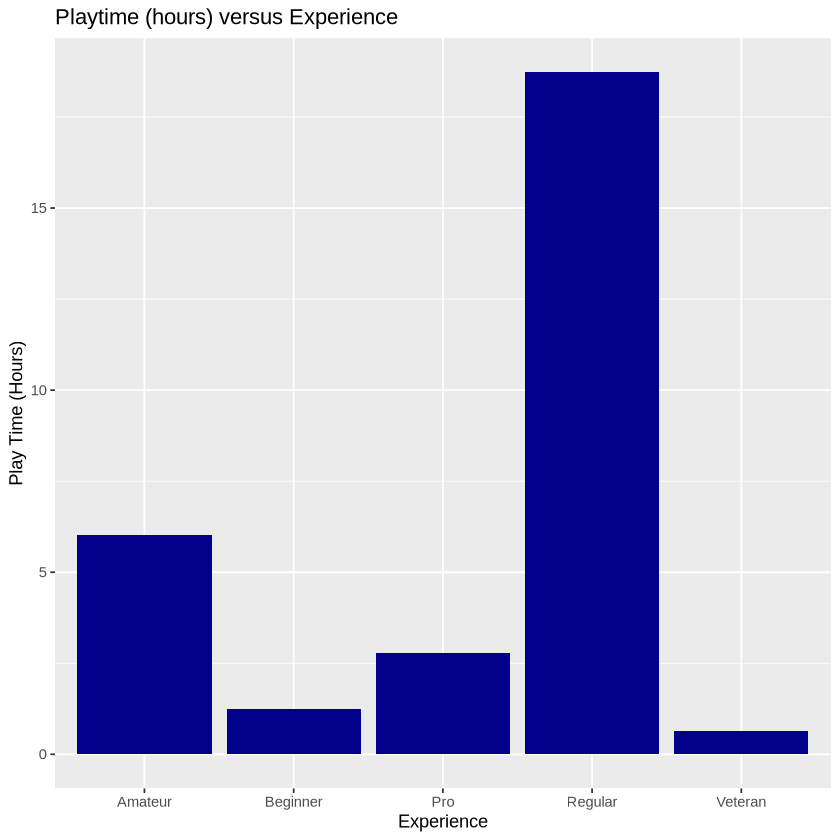

In [58]:
#experience vs avg played hours
play_time_v_experience <- data_qualitative |>
    select(experience, played_hours) |>
    group_by(experience) |>
    summarize(played_hours = mean(played_hours)) |>
    ggplot(aes(x = experience, y = played_hours)) + 
        geom_bar(stat='identity', fill="dark blue") + 
        labs(title = "Playtime (hours) versus Experience", x = "Experience", y = "Play Time (Hours)")
play_time_v_experience


From this, we see that there is indeed a relationship between play time and experience that we did not see with the scatter plot above. Here we see that amateurs and regular players play the most.